This notebook is intended to provide a plot showing how the DTW decreases as the evolutionary algorithm iterates.

Why? To give a reference point when looking at our actual "DTW" results, since the normalized DTW is a really tricky number to interpret by itself.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from plotnine import *

In [3]:
# Read in evolutionary algorithm log
df = pd.read_json('evo_log_2021-09-29 11:00:28.884944.json', lines=True)

In [4]:
to_keep = [c for c in df.columns if '#' not in c]
df = df[to_keep + ['#loss']]
df = df.rename(columns={'#loss' : 'loss'})
df = df.reset_index()

In [7]:
df.head()

,index,coupling_constant,damping_coefficient,mech_spring_constant,loss
0,0,1.229449,0.740605,1.296455,2.385519
1,1,0.254433,1.832512,0.560153,2.022071
2,2,0.679871,0.913589,2.471559,2.763497
3,3,3.967348,4.651746,3.811187,0.331948
4,4,1.935824,2.235696,0.088694,0.850067


In [8]:
# Simulate each one of these parameter choices, and calculate the normalized DTW for them.
import copy
import json

from unified_model.utils.utils import collect_samples
from unified_model.evaluate import Measurement
from unified_model import UnifiedModel
from unified_model.mechanical_components import MassProportionalDamper, MechanicalSpring
from unified_model.coupling import CouplingModel
from unified_model import metrics

# First let's get the input excitations
samples = collect_samples(
    base_path='../data/2019-05-23/',
    acc_pattern='A/*acc*.csv',
    adc_pattern='A/*adc*.csv',
    video_label_pattern='A/*labels*.csv'
)

In [8]:
df.head()

,index,coupling_constant,damping_coefficient,mech_spring_constant,loss
0,0,1.229449,0.740605,1.296455,2.385519
1,1,0.254433,1.832512,0.560153,2.022071
2,2,0.679871,0.913589,2.471559,2.763497
3,3,3.967348,4.651746,3.811187,0.331948
4,4,1.935824,2.235696,0.088694,0.850067


In [9]:
# Let's load our prototype model config
with open('prototype_config.json') as f:
    base_config = json.load(f)
    
# Let's generate all our parameter sets from our log file
params = []
for _, row in df.iterrows():
    param_set = [
        ('mechanical_model.damper.damping_coefficient', row['damping_coefficient']),
        ('coupling_model.coupling_constant', row['coupling_constant']),
        ('mechanical_model.mechanical_spring.damping_coefficient', row['mech_spring_constant'])
    ]
    params.append(param_set)

In [10]:
# Need to do this when working from home
base_config['mechanical_model']['magnetic_spring']['fea_data_file'] = '/home/michael/Nextcloud/PhD/Python/unified_model/data/magnetic-spring/10x10alt.csv'
base_config['electrical_model']['flux_model']['curve_model_path'] = '/home/michael/Nextcloud/PhD/Python/unified_model/data/flux_curve_model/flux_curve_model_2021_05_11.model'

# Run the batch (only need to do this once)

In [55]:
# And let's solve in batch
from unified_model import batch

batch.solve_for_batch(
    base_model_config=base_config,
    params=params,
    samples=samples,
    mech_pred_expr='x3-x1',
    mech_metrics={
        'dtw_mech_norm': metrics.dtw_euclid_norm_by_length
    },
    elec_pred_expr='g(t, x5)',
    elec_metrics={
        'dtw_elec_norm': metrics.dtw_euclid_norm_by_length,
        'rms_perc_diff': metrics.root_mean_square_percentage_diff,
        'loss_': metrics.power_difference_perc
    }
)

2021-10-06 17:40:52,670	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


✨ Running batch 1 out of 8... 
🕙 Still waiting for 1180 jobs...
🕙 Still waiting for 636 jobs...
🕙 Still waiting for 81 jobs...
🕙 Still waiting for 0 jobs...
✨ Running batch 2 out of 8... 
🕙 Still waiting for 1188 jobs...
🕙 Still waiting for 646 jobs...
🕙 Still waiting for 109 jobs...
🕙 Still waiting for 0 jobs...
✨ Running batch 3 out of 8... 
🕙 Still waiting for 1215 jobs...
🕙 Still waiting for 655 jobs...
🕙 Still waiting for 107 jobs...
🕙 Still waiting for 0 jobs...
✨ Running batch 4 out of 8... 
🕙 Still waiting for 1186 jobs...
🕙 Still waiting for 639 jobs...
🕙 Still waiting for 93 jobs...
🕙 Still waiting for 0 jobs...
✨ Running batch 5 out of 8... 
🕙 Still waiting for 1195 jobs...
🕙 Still waiting for 657 jobs...
🕙 Still waiting for 111 jobs...
🕙 Still waiting for 0 jobs...
✨ Running batch 6 out of 8... 
🕙 Still waiting for 1192 jobs...
🕙 Still waiting for 644 jobs...
🕙 Still waiting for 95 jobs...
🕙 Still waiting for 0 jobs...
✨ Running batch 7 out of 8... 
🕙 Still waiting for 1171

# Plot

In [1]:
import pandas as pd
import numpy as np

df_results = pd.read_parquet('batch_run_2021-10-06 17:40:50.679876.parquet/')

# Rename columns to be more friendly
df_results = df_results.rename(columns={
    'mechanical_model.damper.damping_coefficient': 'damping_coefficient',
    'coupling_model.coupling_constant': 'coupling_constant',
    'mechanical_model.mechanical_spring.damping_coefficient': 'mech_spring_damper'
})

df_results['loss_'] = np.abs(df_results['loss_'])  # Make sure loss is absolute (it is in the evolutionary algo)

df_results['abs_rms_perc_diff'] = np.abs(df_results['rms_perc_diff'])
#df_results = df_results.query('abs_rms_perc_diff < 2')

# Calculate the mean across all inputs for each parameter set
df_mean = df_results.groupby(['damping_coefficient', 'coupling_constant', 'mech_spring_damper']).mean().reset_index()
df_mean.head()

,damping_coefficient,coupling_constant,mech_spring_damper,input,dtw_mech_norm,dtw_elec_norm,rms_perc_diff,loss_,abs_rms_perc_diff
0,0.0,0.0,0.000000,4,0.012676,0.185080,4.449276,34.982494,4.449276
1,0.0,0.0,0.011003,4,0.012254,0.177374,4.424063,34.319332,4.424063
2,0.0,0.0,0.013214,4,0.012113,0.175458,4.382876,33.884610,4.382876
3,0.0,0.0,0.039935,4,0.012490,0.182314,4.462978,35.073598,4.462978
4,0.0,0.0,0.041483,4,0.012177,0.178488,4.406423,33.877258,4.406423


In [2]:
# Move to Tidy data
df_melt = df_mean.melt(id_vars=['loss_'], value_vars=['dtw_mech_norm', 'dtw_elec_norm', 'rms_perc_diff'])

# Ensure order in the plot
df_melt['variable'] = pd.Categorical(df_melt['variable'], ['dtw_mech_norm', 'dtw_elec_norm', 'rms_perc_diff'], ordered=True)

df_melt.head()

,loss_,variable,value
0,34.982494,dtw_mech_norm,0.012676
1,34.319332,dtw_mech_norm,0.012254
2,33.884610,dtw_mech_norm,0.012113
3,35.073598,dtw_mech_norm,0.012490
4,33.877258,dtw_mech_norm,0.012177


In [4]:
# Create DataFrame that'll hold the annotations
df_annot = df_mean.sort_values(by='loss_')[['dtw_mech_norm', 'dtw_elec_norm', 'rms_perc_diff', 'loss_']].reset_index(drop=True).iloc[0:1, :].melt(id_vars=['loss_'])
df_annot['x'] = 10 
df_annot['xend'] = df_annot['loss_'] + 1  # add an offset
df_annot['y']  = df_annot['value'] 
df_annot['yend']  = df_annot['value']

# NB: Ensure same order
df_annot['variable'] = pd.Categorical(df_annot['variable'], dtype=df_melt['variable'].dtype)

df_annot.head()

,loss_,variable,value,x,xend,y,yend
0,0.168029,dtw_mech_norm,0.003871,10,1.168029,0.003871,0.004021
1,0.168029,dtw_elec_norm,0.029159,10,1.168029,0.029159,0.029309
2,0.168029,rms_perc_diff,-0.025756,10,1.168029,-0.025756,-0.025606


/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 14 x 3 in image.
/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/loss_metric_plot.pdf
/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


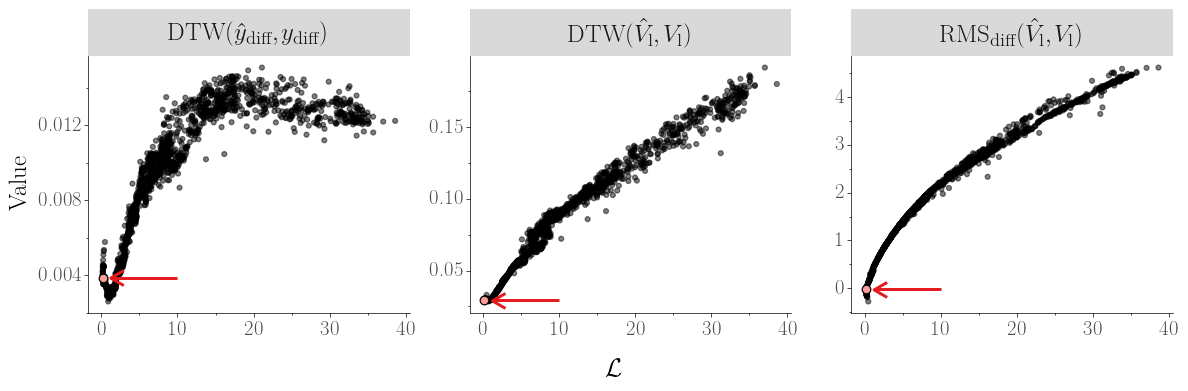

<ggplot: (-9223363306996096666)>

In [10]:
from plotnine import *
from plotnine_phd_theme.phd_theme import phd_theme_bigger, phd_theme
import matplotlib

# Set LaTeX flags
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r"""\usepackage{amsmath}
\usepackage{lmodern}
"""

facet_lookup = {
    'dtw_mech_norm': r'$\text{DTW}(\hat{y}_{\text{diff}},y_{\text{diff}})$',
    'dtw_elec_norm': r'$\text{DTW}(\hat{V}_{\text{l}},V_{\text{l}})$',
    'rms_perc_diff': r'$\text{RMS}_{\text{diff}}(\hat{V}_{\text{l}},V_{\text{l}})$',
}    

p = ggplot(aes(x='loss_', y='value'), df_melt)
p  =(
    p
    + geom_point(alpha=0.5)
    + facet_wrap('variable', scales='free', labeller=lambda x: facet_lookup[x], nrow=1)
    + geom_point(data=df_annot, fill='#fc9d9aff', size=3)
    + geom_segment(aes(x='x', xend='xend', y='y', yend='yend'), data=df_annot, color='#e41a1c', arrow=arrow(type='open', length=0.15), size=1.2)
    + phd_theme_bigger()
    + theme(
        figure_size=(14, 3),
        aspect_ratio=0.8,
        panel_spacing_x=0.6,
        strip_text=element_text(margin={'t': 6, 'b': 6}),
        axis_title_x=element_text(margin={'t': 15}))
    + ylab('Value')
    + xlab(r'$\mathcal{L}$')
)
p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/loss_metric_plot.pdf')
p